# Heart Failure Clinical Records
This notebook is for the programming assignment for the postdoc position "Machine Learning Engineer" @ BU.

TODO LIST:

* Do some more visual EDA exploring correlations and general overviews of the data.
    * Outliers
        * Scatterplots and boxplots.
        * I'm debating against removing the outliers because they very well may be the reason people die, the fact that they are outliers in otherwise healthy values.
        * I want to plot their distribution against the death rate and see if there are more deaths in the outliers than in standard data.
    * General plots of the variables
    * How many people died on both sides?
    * Is the data unbalanced?
    * Plot different variables against the target graphically.
    * That kinda thing.
* Check skew/kurtosis of values (particularly those chosen).
* Have a think of other checks I can do like scaling.

## Introduction

The data comes from the [UCL Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records#).  It contains medical records of 299 patients who had heart failure and consists of 13 clinical features.  The 13 features are as follows:

* `age` — Age of the patient (years).
* `anaemia` — Decrease of red blood cells or hemoglobin (boolean).
* `high_blood_pressure` — If the patient has hypertension (boolean).
* `creatinine_phosphokinase` — Level of the CPK enzyme in the blood (mcg/L).
* `diabetes` — If the patient has diabetes (boolean).
* `ejection_fraction` — Percentage of blood leaving the heart at each contraction (percentage/100).
* `platelets` — Platelets in the blood (kiloplatelets/mL).
* `sex` — Woman or man (binary).
* `serum_creatinine` — Level of serum creatinine in the blood (mg/dL).
* `serum_sodium` — Level of serum sodium in the blood (mEq/L).
* `smoking` — If the patient smokes or not (boolean).
* `time` — Follow-up period (days).
* `DEATH_EVENT` — If the patient deceased during the follow-up period (boolean).

The target variable being predicted is`DEATH_EVENT`, a boolean in the form of `1` or `0`.

The paper linked in the dataset's homepage (*Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone". BMC Medical Informatics and Decision Making 20, 16 (2020).*) contains more information about this from a medical standpoint (which is welcome as I am no clinical scientist!).

Their title suggests that we can use only `serum_creatinine` and `ejection_fraction` to predict this.  Given their findings, it's probable that feature engineering wouldn't bring much luck.

## Load Data
Let's begin by importing everything.

In [1]:
import pandas as pd

all_data = pd.read_csv('./data/heart_failure_clinical_records_dataset.csv')

## Data Summary

Let's begin by checking out the data. What are the ranges? Are there any missing values? What are the distributions? That kind of thing.

### Missing Values

Luckily there are no missing values!

In [2]:
print('Total rows with a null element:', sum(all_data.isnull().any(1)))

Total rows with a null element: 0


### Data Types

Looking at the column data types below, I'm suspicious of `age` and `platelets`.  We could also go after the 64-bit nature and reduce the data size, or could even convert booleans represented as integers as something smaller, but this data is so small that it will gain no real benefit.

In [3]:
all_data.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

Looking at the `age` column, we can see that two values are set as floats.  Given the low number of elements and the closeness to an integer, it's worth just rounding them up.

In [4]:
all_data[all_data.age.map(lambda x: not x.is_integer())]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
185,60.667,1,104,1,30,0,389000.0,1.5,136,1,0,171,1
188,60.667,1,151,1,40,1,201000.0,1.0,136,0,0,172,0


In [5]:
import numpy as np

# Sticking with int64 as mentioned above. Could be brought down but this data doesn't need it.
all_data['age'] = all_data.age.round(0).astype(np.int64)

In [6]:
print('age is now:', all_data.age.dtype)

# Check the two above values.
print(f'Entry 185 is now {all_data.age.iloc[185]}')
print(f'Entry 188 is now {all_data.age.iloc[188]}')

age is now: int64
Entry 185 is now 61
Entry 188 is now 61


Let's now deal with `platelets`.  Notice how all 25 have the same 'incorrect' value.  The value as an integer is six digits long and falls well within the range of the other data.  Having looked through the paper of this dataset and the original paper, they don't really mention this error, so I will again convert to integer since it seems quite reasonable of a value.  I'm still a little suspicious though and given more time would perhaps investigate this more.

In [7]:
broken_platelets = all_data[all_data.platelets.map(lambda x: not x.is_integer())]['platelets']
print(f'Total number of odd platelets: {len(broken_platelets)}')
print(f'Unique values in platelets: {broken_platelets.unique()}')

Total number of odd platelets: 25
Unique values in platelets: [263358.03]


In [8]:
all_data['platelets'] = all_data.platelets.round(0).astype(np.int64)

In [9]:
print('platelets is now:', all_data.platelets.dtype)

platelets is now: int64


## Data Summary

The paper this data comes with describes the ranges in which the data falls.  Looking at the describe output below, there are some mismatches with their reportings.

* They report `serum_sodium` having a minimum of `114`, but it's actually `113`.  I cannot see this being and issue and it is likely a misreporting on their behalf.
* They report `platelets` as being `[25.01, ..., 850.00]`, but here it is much larger than that.  They have multiplied by `0.001` to convert it.  I will leave it for now.

In [10]:
all_data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.836120,0.431438,581.839465,0.418060,38.083612,0.351171,263358.026756,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


# TEST AREA

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<AxesSubplot:xlabel='creatinine_phosphokinase'>

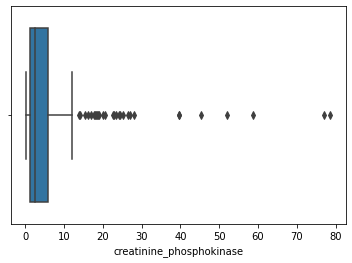

In [33]:
sns.boxplot(all_data['creatinine_phosphokinase'] * 0.01)
# sns.boxplot(all_data['DEATH_EVENT'], all_data['serum_creatinine'])

In [96]:
import numpy as np

def test_outliers_df(df, col):
    low=0.05
    high=0.95
    q_df = df.quantile([low, high])
    tmp = df[(df[col] > q_df.loc[low, col]) & (df[col] < q_df.loc[high, col])]

    print(f'{col}:')
    print(f'\t{len(tmp)}/{len(df)} outliers')

    num_died = sum(tmp['DEATH_EVENT'] == 1)
    print(f'\t{num_died}/{len(tmp)} outliers died ({round((num_died/len(tmp))*100, 2)})%')
    
    total_deaths = sum(df['DEATH_EVENT']==1)
    print(f"\tGlobally, that's {num_died}/{total_deaths} ({round((num_died/total_deaths)*100, 2)}%)")


test_outliers_df(all_data, 'creatinine_phosphokinase')

# TODO: Consider logging columns.
# Also check their skew and kurtosis while I'm here.

creatinine_phosphokinase:
	268/299 outliers
	87/268 outliers died (32.46)%
	Globally, that's 87/96 (90.62%)


# END TEST AREA

## Correlations / Feature Choosing

### Correlations

Let's now look at the correlation of all of the variables with the target variable.

One thing to consider here is the data size.  Correlations shown below that are low (i.e. hardly correlated) may very well actually be correlated higher than we think if given a larger dataset.

Looking at the correlations below, the only columns with a reasonable level of correlation (arbitrarily chosen!) are `age`, `ejection_fraction`, `serum_creatine`, `serum_sodium`, and `time`.

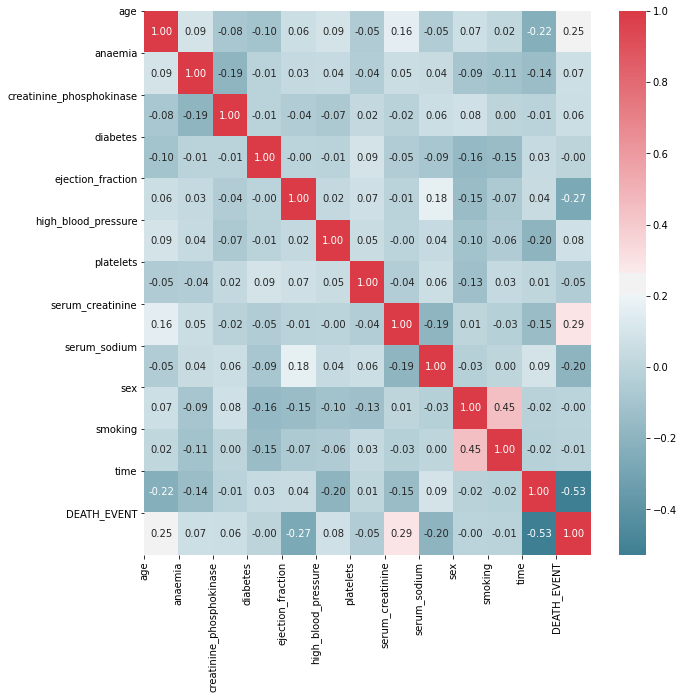

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

corr = all_data.corr()
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot=True, fmt='.2f')
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

### Feature Choosing

Let's begin by dropping all but those columns from the dataset.  This could have been automated using the correlation matrix given a threshold, but the number of columns and reasonable correlations are small enough to do it by hand.

Realistically, all of these variables likely won't be used (just as how the paper found two to be sufficient).  Another consideration is the size of the data impacting the number of variables we should be picking.  Given the small sample size, having too many variables risks whichever algorithm we choose not being able to find any patterns (whereas given more data and more time it may be able to do so).

In [12]:
all_data = all_data[['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time', 'DEATH_EVENT']]

## Data Preparation

Let's prepare the data for the machine learning pipeline!  This involves, in this case, splitting off the `X` and `y` data (variables and target), then splitting it off for a test set since one wasn't provided separately.

In [13]:
from sklearn.model_selection import train_test_split

X = all_data.drop('DEATH_EVENT', axis=1).values
y = all_data['DEATH_EVENT'].values

TEST_SIZE = 0.2
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [30]:
# DEBUG:
print(X_test[11])
print(y_test[11])

[ 70.   25.    1.2 142.   66. ]
1


## Modeling

Let's begin by doing a random forest with a bit of hyperparameter optimizing.

In [15]:
# A handy dandy function for plotting learning curves.
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_log_loss')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/Users/daniel/.virtualenv/default/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 128 is smaller than n_iter=200. Running 128 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/daniel/.virtualenv/default/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Log Loss: -0.34406787747456785 / {'rf__n_estimators': 50, 'rf__min_samples_split': 4, 'rf__max_features': 'auto', 'rf__max_depth': 16}


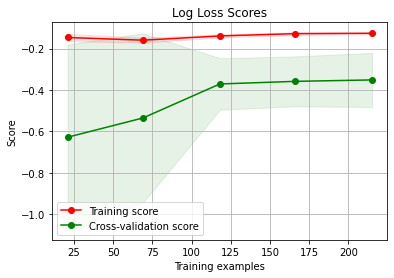

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Splitting the data.
kfold = StratifiedKFold(n_splits=10)

# Pipeline definition.
pl = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

# Search grid tuning.
param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__max_depth': [2, 4, 8, 16],
    'rf__min_samples_split': [2, 3, 4, 5]
}
cv = RandomizedSearchCV(
    pl, param_grid, iid=False, cv=kfold, n_jobs=-1, random_state=RANDOM_STATE, scoring='neg_log_loss', n_iter=200
)

# Fit model.
cv.fit(X_train, y_train)
print(f'Log Loss: {cv.best_score_} / {cv.best_params_}')

# Plot the learning curve.
plot_learning_curve(cv.best_estimator_, 'Log Loss Scores', X_train, y_train, cv=kfold)
plt.show()

## Predictions (Testing)

In [17]:
preds = cv.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Accuracy: {accuracy_score(y_test, preds)}')

F1 Score: 0.7058823529411765
Accuracy: 0.8333333333333334


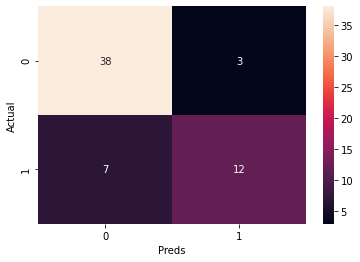

In [19]:
import seaborn as sns

df = pd.DataFrame({
    'Actual': y_test,
    'Preds': preds
})
cm = pd.crosstab(df['Actual'], df['Preds'], rownames=['Actual'], colnames=['Preds'])

sns.heatmap(cm, annot=True)
plt.show()

In [20]:
import joblib

joblib.dump(cv, 'model.pkl')

['model.pkl']

In [ ]:
# TODO: Calculate TP/TN rate
# TODO: Plot ROC AUC
# TODO: PR AUC